In [13]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [14]:
from IPython.display import HTML
try:
    myf = open('custom.css')
    htmlstring =  "<style>%s </style>" %(myf.read())
    HTML(htmlstring)
except IOError:
    print "no file"


# Decomposing Classification For Mixture Models
By Kyle Cranmer, May 2015
@kylecranmer

A few slides related to Section 5.4 of *Approximating Likelihood Ratios with Calibrated Discriminative Classifiers*, 
http://arxiv.org/abs/1506.02169

[![CC BY](https://i.creativecommons.org/l/by/4.0/88x31.png)](https://creativecommons.org/licenses/by/4.0/)

# Introduction

We consider the situation where you want to train a classifier between two different classes of events, and each  class of events is generated from a mixture model

\begin{equation}
p(x|\theta)=\sum_c w_c(\theta) p_c(x| \theta) \;,
\end{equation}

where $x$ is a high-dimensional feature vector, the index $c$ represents different classes of events with corresponding mixture coefficient $w_c(\theta)$ and probability distribution $p_c(x|\theta)$. 



Our goal is to train a classifier to discriminate between $p(x|\theta_0)$ and $p(x|\theta_1)$.

We are considering the situation that both the coefficients and the distributions are parametrized by $\theta$, which may have several components. 

Special case: the mixture coefficents are not really functions of $\theta$. This can be accomodated by this formalism by identifying one of the components of $\theta$ with the mixture coefficient, i.e. $w_c(\theta) = \theta_i$ 

Special case: the component distributions don't depend on $\theta$, i.e. $p_c(x|\theta) = p_c(x)$ 

# The problem

The simplest thing we can do is:

  1. Generate training data $\{(x,y=0)\}$ from $p(x|\theta_0)$ and $\{(x,y=1)\}$ from $p(x|\theta_1)$, where $y$ is the class label
  1. Train classifier based on this training data
  



This is fine, but if the difference between  $p(x|\theta_0)$ and $p(x|\theta_1)$ is due to a component with a small $w_c$, then most of the training examples do not focus on the relevant difference between the two classes.

# An example

In particle physics, often one model is the *background-only* hypothesis
  * $p(x|\theta_0) = p_b(x)$ is the only component
  
the other  is the *signal-plus-background* hypothesis, 
   * $p(x|\theta_1) = w_s p_s(x) + (1-w_s) p_b(x)$

and $w_s$ is very small.



## Capacity Focusing Technique

In order to focus the capacity of the classifier on the relevant regions of $x$, the classifier is not trained to distinguish $p(x|\theta_0)$ vs. $p(x|\theta_1)$. 

Instead, a classifier is trained to distinguish $p_b(x)$ vs. $p_s(x)$.

This works because the likleihood ratio $p_s(x)/p_b(x)$ is 1-to-1 with $p(x|\theta_0)/p(x|\theta_1)$. 


# Decomposing the classification 

We can generalize this capacity focusing technique to comparisons of mixture models, by rewriting the desired likelihood ratio

\begin{eqnarray}
\frac{p(x|\theta_0)}{p(x|\theta_1)} & =& \frac{\sum_c w_c(\theta_0) p_c(x| \theta_0)}{\sum_{c'} w_{c'}(\theta_1) p_{c'}(x| \theta_1)} 
\\
%&=& \sum_c \frac{ w_c(\theta_0) p_c(x| \theta_0)}{\sum_{c'} w_{c'}(\theta_1) p_{c'}(x| \theta_1)} \\
%&=& \sum_c \left[ \frac{\sum_{c'} w_{c'}(\theta_1) p_{c'}(x| \theta_1)}{ w_c(\theta_0) p_c(x| \theta_0)}  \right]^{-1} \\
&=& \sum_c \left[ \sum_{c'} \frac{ w_{c'}(\theta_1)}{w_c(\theta_0)} \frac{ p_{c'}(x| \theta_1)}{  p_c(x| \theta_0)}  \right]^{-1} \\
&=& \sum_c \left[ \sum_{c'} \frac{ w_{c'}(\theta_1)}{w_c(\theta_0)} \frac{ p_{c'}(s_{c,c',\theta_0, \theta_1}| \theta_1)}{ p_c(s_{c,c',\theta_0, \theta_1}| \theta_0)}  \right]^{-1} 
\end{eqnarray}



\begin{eqnarray}
\frac{p(x|\theta_0)}{p(x|\theta_1)} & =& \frac{\sum_c w_c(\theta_0) p_c(x| \theta_0)}{\sum_{c'} w_{c'}(\theta_1) p_{c'}(x| \theta_1)} 
\\
&=& \sum_c \left[ \sum_{c'} \frac{ w_{c'}(\theta_1)}{w_c(\theta_0)} \frac{ p_{c'}(x| \theta_1)}{  p_c(x| \theta_0)}  \right]^{-1} \\
%&=& \sum_c \left[ \sum_{c'} \frac{ w_{c'}(\theta_1)}{w_c(\theta_0)} \frac{ p_{c'}(s_{c,c',\theta_0, \theta_1}| \theta_1)}{ p_c(s_{c,c',\theta_0, \theta_1}| \theta_0)}  \right]^{-1} 
\end{eqnarray}




The second line is a trivial, but useful decomposition into pair-wise classification between $p_{c'}(x|\theta_1)$ and $p_c(x|\theta_0)$.  




In the situation where the only free parameters of the mixture model are the coefficients $w_c$, then the distributions $p_{c}(s_{c,c',\theta_0, \theta_1}| \theta)$ are independent of $\theta$ and can be pre-computed (after training the discriminative classifier, but before performing the generalized likelihood ratio test). 



# Demonstration

Consider these three distributions for the components

In [4]:
def f0(x):
    return np.exp(x*-1)
def f1(x):
    return np.cos(x)**2+.01
def f2(x):
    return np.exp(-(x-2)**2/2)
fs = [f0, f1, f2]

with these mixture coefficients

In [5]:
w0 = [.1,.2,.7]
w1 = [.2,.5,.3]

Corresponding to the two mixture models

In [6]:
def F0(x):
    sum = 0.
    for w, f in zip(w0, fs):
        sum += w*f(x)
    return sum
def F1(x):
    sum = 0.
    for w, f in zip(w1, fs):
        sum+= w*f(x)
    return sum

# Visualization of the models

In [7]:
xarray = np.linspace(0,5,100)

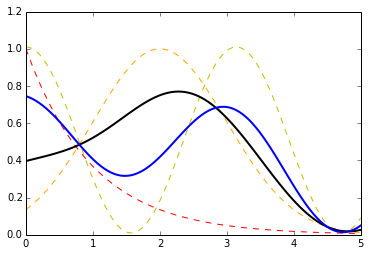

In [8]:
plt.plot(xarray,f0(xarray), c='r', ls='--')
plt.plot(xarray,f1(xarray), c='y', ls='--')
plt.plot(xarray,f2(xarray), c='orange', ls='--')
plt.plot(xarray,F0(xarray), c='black', ls='-', lw=2)
plt.plot(xarray,F1(xarray), c='b', ls='-', lw=2)

# Visualization of the target likleihood ratio


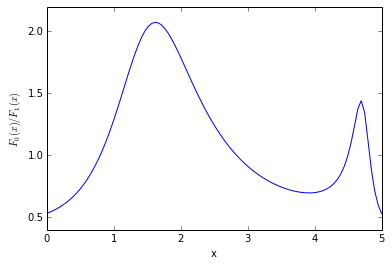

In [9]:
plt.plot(xarray,F0(xarray)/F1(xarray))
plt.xlabel('x')
plt.ylabel('$F_0(x)/F_1(x)$')

# Construction of the decomposed ratio

Recall the equation

\begin{eqnarray}
\frac{p(x|\theta_0)}{p(x|\theta_1)} & =& \frac{\sum_c w_c(\theta_0) p_c(x| \theta_0)}{\sum_{c'} w_{c'}(\theta_1) p_{c'}(x| \theta_1)} 
\\
&=& \sum_c \left[ \sum_{c'} \frac{ w_{c'}(\theta_1)}{w_c(\theta_0)} \frac{ p_{c'}(x| \theta_1)}{  p_c(x| \theta_0)}  \right]^{-1} \\
%&=& \sum_c \left[ \sum_{c'} \frac{ w_{c'}(\theta_1)}{w_c(\theta_0)} \frac{ p_{c'}(s_{c,c',\theta_0, \theta_1}| \theta_1)}{ p_c(s_{c,c',\theta_0, \theta_1}| \theta_0)}  \right]^{-1} 
\end{eqnarray}



In [10]:
def altRatio(x):
    sum = 0.
    for i,w in enumerate(w0):
        if(w==0):
            continue
        innerSum = 0.
        for j,wp in enumerate(w1):
            innerSum+= wp/w*fs[j](x)/fs[i](x)
        sum+=1./innerSum
    return sum


# Visualization of the pair-wise comparisons

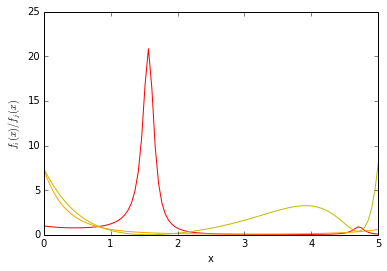

In [11]:
plt.plot(xarray,fs[0](xarray)/fs[1](xarray), c='r')
plt.plot(xarray,fs[0](xarray)/fs[2](xarray), c='orange')
plt.plot(xarray,fs[1](xarray)/fs[2](xarray), c='y')
plt.xlabel('x')
plt.ylabel('$f_i(x)/f_j(x)$')

# Comparison of the original and decomposed ratio

*It works!*

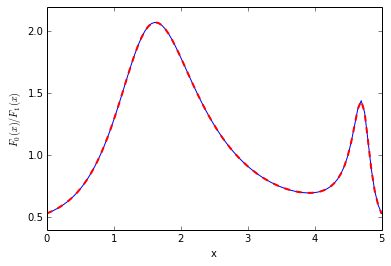

In [12]:
plt.plot(xarray,F0(xarray)/F1(xarray))
plt.plot(xarray,altRatio(xarray), ls='--', c='r', lw=2)
plt.xlabel('x')
plt.ylabel('$F_0(x)/F_1(x)$')

# Going further




So far what we showed was a numerical example of a simple re-writing of the target likelihood ratio.
When $x$ is high-dimensional we usually can't evaluate $p_c(x|\theta)$.  



However, we can use Theorem 1 from [arxiv:1506.02169]( http://arxiv.org/abs/1506.02169) to relate the high-dimensional likelihood ratio into an equivalent calibrated likelihood ratio based on the univariate density of the corresponding classifier, denoted $s_{c,c',\theta_0, \theta_1}$. 

\begin{eqnarray}
\frac{p(x|\theta_0)}{p(x|\theta_1)} & =& \frac{\sum_c w_c(\theta_0) p_c(x| \theta_0)}{\sum_{c'} w_{c'}(\theta_1) p_{c'}(x| \theta_1)} 
\\
&=& \sum_c \left[ \sum_{c'} \frac{ w_{c'}(\theta_1)}{w_c(\theta_0)} \frac{ p_{c'}(x| \theta_1)}{  p_c(x| \theta_0)}  \right]^{-1} \\
&=& \sum_c \left[ \sum_{c'} \frac{ w_{c'}(\theta_1)}{w_c(\theta_0)} \frac{ p_{c'}(s_{c,c',\theta_0, \theta_1}| \theta_1)}{ p_c(s_{c,c',\theta_0, \theta_1}| \theta_0)}  \right]^{-1} 
\end{eqnarray}


# Technical notes

These slides were made with IPython3 and Project Jupyter's nbconvert. 
The notebook is [here](https://github.com/cranmer/parametrized-learning/blob/master/DecomposingTestsOfMixtureModels.ipynb).

Local development was based on
`ipython nbconvert --to slides DecomposingTestsOfMixtureModels.ipynb --post serve`

Once I was happy, 
` ipython nbconvert --to slides DecomposingTestsOfMixtureModels.ipynb  --reveal-prefix https://cdn.jsdelivr.net/reveal.js/2.6.2`

Double check with
`python -m SimpleHTTPServer 8000`

and then I put the resulting ` DecomposingTestsOfMixtureModels.slides.html` on my web server.

Note, you can also point nbviewer directly to the notebook and [view them as slides](http://nbviewer.ipython.org/format/slides/github/cranmer/parametrized-learning/tree/master/DecomposingTestsOfMixtureModels.ipynb#/)